## Load Event Data

In [1]:
import pandas as pd

df_home_page = pd.read_csv('/content/home_page_table.csv')
df_search_page = pd.read_csv('/content/search_page_table.csv')
df_payment_page = pd.read_csv('/content/payment_page_table.csv')
df_payment_confirmation = pd.read_csv('/content/payment_confirmation_table.csv')

print("Home Page Data (df_home_page):")
print(df_home_page.head())
print("\nSearch Page Data (df_search_page):")
print(df_search_page.head())
print("\nPayment Page Data (df_payment_page):")
print(df_payment_page.head())
print("\nPayment Confirmation Data (df_payment_confirmation):")
print(df_payment_confirmation.head())

Home Page Data (df_home_page):
   user_id       page
0   313593  home_page
1   468315  home_page
2   264005  home_page
3   290784  home_page
4   639104  home_page

Search Page Data (df_search_page):
   user_id         page
0    15866  search_page
1   347058  search_page
2   577020  search_page
3   780347  search_page
4   383739  search_page

Payment Page Data (df_payment_page):
   user_id          page
0   253019  payment_page
1   310478  payment_page
2   304081  payment_page
3   901286  payment_page
4   195052  payment_page

Payment Confirmation Data (df_payment_confirmation):
   user_id                       page
0   123100  payment_confirmation_page
1   704999  payment_confirmation_page
2   407188  payment_confirmation_page
3   538348  payment_confirmation_page
4   841681  payment_confirmation_page


### Merging Event Data

In [2]:
df_merged = pd.merge(df_home_page, df_search_page, on='user_id', how='outer', suffixes=('_home', '_search'))
df_merged = pd.merge(df_merged, df_payment_page, on='user_id', how='outer', suffixes=('_search', '_payment'))
df_merged = pd.merge(df_merged, df_payment_confirmation, on='user_id', how='outer', suffixes=('_payment', '_confirmation'))

print("Merged DataFrame Head:")
print(df_merged.head())
print("\nMerged DataFrame Info:")
df_merged.info()

Merged DataFrame Head:
   user_id  page_home  page_search  page_payment page_confirmation
0       17  home_page  search_page           NaN               NaN
1       28  home_page          NaN           NaN               NaN
2       37  home_page  search_page           NaN               NaN
3       38  home_page  search_page  payment_page               NaN
4       55  home_page          NaN           NaN               NaN

Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90400 entries, 0 to 90399
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            90400 non-null  int64 
 1   page_home          90400 non-null  object
 2   page_search        45200 non-null  object
 3   page_payment       6030 non-null   object
 4   page_confirmation  452 non-null    object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


### Merging User Data

In [3]:
df_user = pd.read_csv('/content/user_table.csv')

print("User Data (df_user):")
print(df_user.head())

df_merged = pd.merge(df_merged, df_user, on='user_id', how='left')

print("\nMerged DataFrame with Device Type Head:")
print(df_merged.head())
print("\nMerged DataFrame with Device Type Info:")
df_merged.info()

User Data (df_user):
   user_id        date   device     sex
0   450007  2015-02-28  Desktop  Female
1   756838  2015-01-13  Desktop    Male
2   568983  2015-04-09  Desktop    Male
3   190794  2015-02-18  Desktop  Female
4   537909  2015-01-15  Desktop    Male

Merged DataFrame with Device Type Head:
   user_id  page_home  page_search  page_payment page_confirmation  \
0       17  home_page  search_page           NaN               NaN   
1       28  home_page          NaN           NaN               NaN   
2       37  home_page  search_page           NaN               NaN   
3       38  home_page  search_page  payment_page               NaN   
4       55  home_page          NaN           NaN               NaN   

         date   device     sex  
0  2015-04-21  Desktop    Male  
1  2015-04-29  Desktop    Male  
2  2015-02-21   Mobile    Male  
3  2015-03-23   Mobile  Female  
4  2015-02-01  Desktop    Male  

Merged DataFrame with Device Type Info:
<class 'pandas.core.frame.DataFrame'>


## Prepare Funnel Data


In [4]:
funnel_stage_mapping = {
    'page_home': 'Homepage',
    'page_search': 'Search',
    'page_payment': 'Product View',
    'page_confirmation': 'Purchase'
}

# Group by 'device' and count non-null values for each stage column
df_funnel = df_merged.groupby('device')[list(funnel_stage_mapping.keys())].count()

# Rename the columns to user-friendly funnel stage names
df_funnel = df_funnel.rename(columns=funnel_stage_mapping)

print("Funnel Data by Device Type:")
print(df_funnel)

Funnel Data by Device Type:
         Homepage  Search  Product View  Purchase
device                                           
Desktop     60200   30100          3010       150
Mobile      30200   15100          3020       302


## Calculate Funnel Metrics



In [5]:
funnel_stages = ['Homepage', 'Search', 'Product View', 'Purchase']

df_conversion_rates = pd.DataFrame(index=df_funnel.index)

# Calculate step-wise conversion rates
df_conversion_rates['Homepage_to_Search_Conversion'] = df_funnel['Search'] / df_funnel['Homepage']
df_conversion_rates['Search_to_Product_View_Conversion'] = df_funnel['Product View'] / df_funnel['Search']
df_conversion_rates['Product_View_to_Purchase_Conversion'] = df_funnel['Purchase'] / df_funnel['Product View']

print("Conversion Rates by Device Type:")
print(df_conversion_rates)

Conversion Rates by Device Type:
         Homepage_to_Search_Conversion  Search_to_Product_View_Conversion  \
device                                                                      
Desktop                            0.5                                0.1   
Mobile                             0.5                                0.2   

         Product_View_to_Purchase_Conversion  
device                                        
Desktop                             0.049834  
Mobile                              0.100000  


## Visualize Funnel Performance


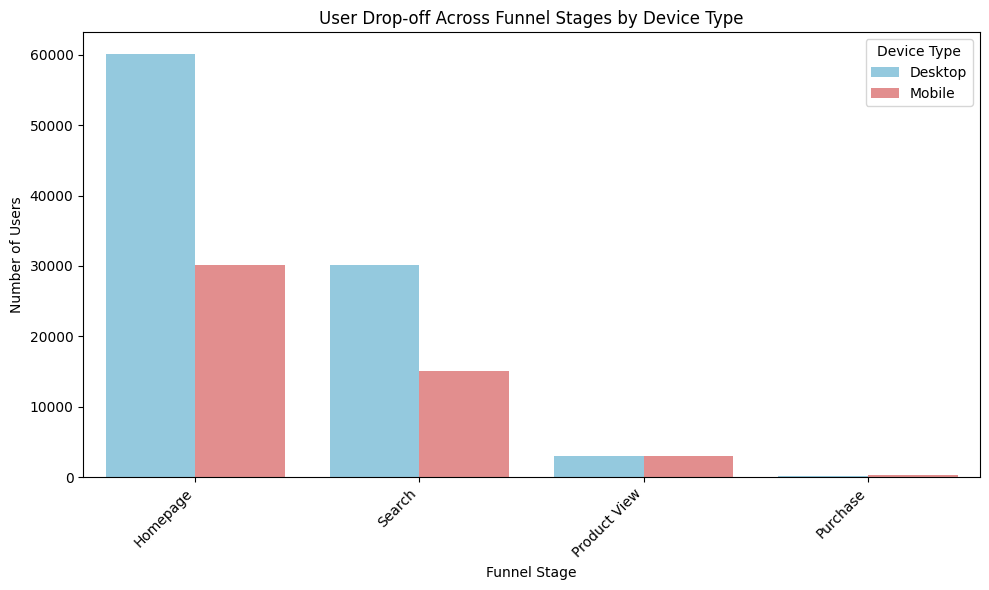

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the df_funnel DataFrame to long format
df_funnel_melted = df_funnel.reset_index().melt(id_vars='device', var_name='stage', value_name='users')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_funnel_melted, x='stage', y='users', hue='device', palette={'Desktop': 'skyblue', 'Mobile': 'lightcoral'})

plt.title('User Drop-off Across Funnel Stages by Device Type')
plt.xlabel('Funnel Stage')
plt.ylabel('Number of Users')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.legend(title='Device Type')
plt.tight_layout()
plt.show()

## Summary:

### Q&A

1.  **Summary of key inferences from the funnel analysis:**
    The funnel analysis reveals significant user drop-offs at various stages, particularly after the Search and Product View stages. Mobile users exhibit substantially better conversion rates in the later stages of the funnel (Search to Product View and Product View to Purchase) compared to desktop users.
2.  **Significant user drop-off points:**
    *   **Search stage:** For desktop users, there's a 90% drop-off from Search to Product View (30,100 users reaching Search, only 3,010 reaching Product View). For mobile, this drop-off is 80% (15,100 users to Search, 3,020 to Product View).
    *   **Product View stage:** For desktop users, there's a significant drop-off from Product View to Purchase, with only 4.98% converting. For mobile users, while better, there's still a 90% drop-off (10% conversion).
3.  **Observed differences in behavior between desktop and mobile users:**
    *   **Homepage to Search**: Both device types show an identical 50% conversion rate.
    *   **Search to Product View**: Mobile users convert at 20%, which is double the desktop conversion rate of 10%.
    *   **Product View to Purchase**: Mobile users convert at 10%, which is approximately double the desktop conversion rate of 4.98%.
    *   **Overall Performance**: Despite starting with fewer users (30,200 vs. 60,200 on homepage), mobile devices lead to more final purchases (302 vs. 150).
4.  **Potential UX friction points:**
    The significantly lower conversion rates for desktop users from Search to Product View and Product View to Purchase suggest potential UX friction points specific to the desktop experience on these pages. This could include issues with product display, information layout, navigation, or the checkout process on desktop that are not present or are better handled on mobile.

### Data Analysis Key Findings

*   **Initial User Distribution**: The analysis started with 60,200 desktop users and 30,200 mobile users on the homepage.
*   **Homepage to Search Conversion**: Both desktop and mobile users showed an identical 50% conversion rate from the Homepage to the Search stage.
*   **Search to Product View Conversion Discrepancy**: Mobile users converted from Search to Product View at a rate of 20%, which is double the desktop conversion rate of 10%. This indicates a significant user drop-off for desktop users at this stage.
*   **Product View to Purchase Conversion Discrepancy**: Mobile users continued to outperform desktop users, with a 10% conversion rate from Product View to Purchase, compared to approximately 4.98% for desktop users.
*   **Total Purchases**: Despite having fewer initial users, mobile devices generated more purchases (302) than desktop devices (150).
*   **Major Drop-off Stages**: The largest proportional drop-offs for desktop users occur between Search and Product View (90% drop-off) and between Product View and Purchase (95% drop-off). For mobile, the largest proportional drop-off is between Product View and Purchase (90% drop-off).

### Insights or Next Steps

*   Investigate the desktop user experience at the Search and Product View stages to understand why conversion rates are significantly lower than for mobile users. This could involve A/B testing different layouts, content, or calls-to-action specific to desktop.
*   Analyze the mobile user journey for elements that contribute to its higher conversion rates in later stages, and consider how these successful patterns could be adapted or implemented for the desktop experience.
